In [31]:
%reset

import keras
import pickle as pk
import matplotlib.pyplot as pl
import matplotlib
import numpy as np
import pdb
import sklearn.model_selection

%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [32]:
# The neural network architecture that we'll use in the example below is based on:
# See https://github.com/eriklindernoren/Keras-GAN/blob/master/context_encoder/context_encoder.py

## Data location and dimensions

In [33]:
#The data are "cutouts" from full-sky maps made from observations by the Planck satellite.
#These maps were constructed at an observing frequency of 857 GHz
data_dir = './cutout_data/'
# this file contains some cutouts that are "off star", i.e. centered at random locations on the sky
# and not on star locations
offstar_file = 'cutouts_1000offstarfirstpass_01.pk'
#The iniital cutouts have a dimension of 200x200.  We'll reduce the dimension to dim_reduced x dim_reduced
#to speed up the analysis
dim_reduced = 64
#We're going to mask out a small part of the center of the cutout with dimension dim_mask x dim_mask
dim_mask = 8

print("angular size of mask (arcmin) = ", dim_mask*1.5)
fwhm_545 = 4.7
sigma_545 = 4.7/np.sqrt(8.*np.log(2))
print("angular size of mask (psf at 545) = ", dim_mask*1.5/sigma_545)


angular size of mask (arcmin) =  12.0
angular size of mask (psf at 545) =  6.01230649795136


## Load the cutout data

In [34]:
#load the data
cutout_data = pk.load(open(data_dir + offstar_file, 'rb'))
print(cutout_data.keys())
ll = cutout_data['l'] # galatic longitude of the cutout
bb = cutout_data['b'] # galactic latitude of the cutout
cutouts_orig = cutout_data['cutouts']
print(cutouts_orig.shape)

dict_keys(['cutouts', 'l', 'b'])
(1000, 200, 200)


## Plot a few cutouts

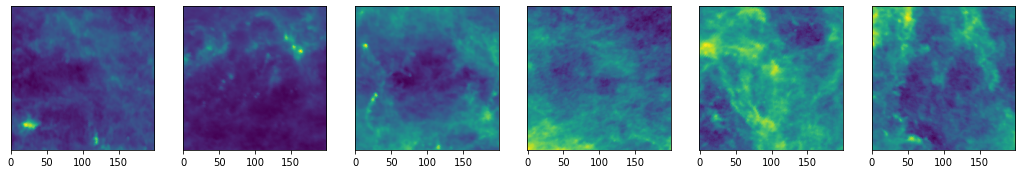

In [35]:
nplots = 6
fig, ax = pl.subplots(1,nplots, figsize = (nplots*3., 4))
for ii in range(0,nplots):
    ax[ii].imshow(np.log(cutouts_orig[ii,:,:]))
    #ax[ii].xaxis.set_visible(False)
    ax[ii].yaxis.set_visible(False)

## Reduce the dimensionality of the cutouts

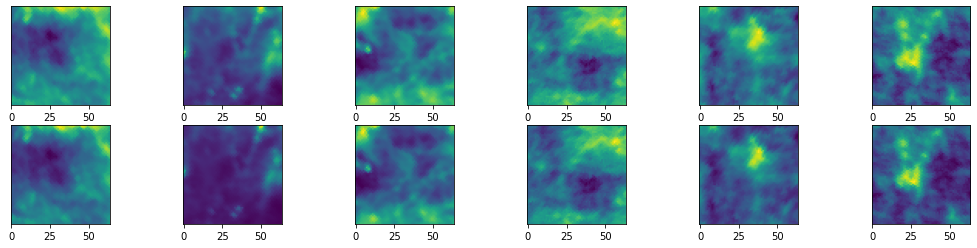

In [36]:
#Select only the center region of the cutouts
orig_dims = cutouts_orig.shape
min_ind = int(orig_dims[1]/2 - dim_reduced/2)
max_ind = int(orig_dims[1]/2 + dim_reduced/2)
cutouts_orig_red = cutouts_orig[:, min_ind:max_ind, min_ind:max_ind]

nplots = 6
fig, ax = pl.subplots(2,nplots, figsize = (nplots*3., 4))
for ii in range(0,nplots):
    ax[0,ii].imshow(np.log(cutouts_orig_red[ii,:,:]))
    ax[1,ii].imshow((cutouts_orig_red[ii,:,:]))
    
    #ax[ii].xaxis.set_visible(False)
    ax[0,ii].yaxis.set_visible(False)
    ax[1,ii].yaxis.set_visible(False)    
    
#fig.savefig('./network_out/example_images.png')

## Test train split

In [37]:
cutouts_train, cutouts_test = sklearn.model_selection.train_test_split(cutouts_orig_red, test_size=0.2)
print(cutouts_train.shape)
print(cutouts_test.shape)
print(dim_reduced)

(800, 64, 64)
(200, 64, 64)
64


## Set up the neural network

In [40]:
from __future__ import print_function, division

from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np

class ContextEncoder():
    def __init__(self):
        self.img_rows = dim_reduced
        self.img_cols = dim_reduced
        self.mask_height = dim_mask
        self.mask_width = dim_mask
        #777777777777
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.missing_shape = (self.mask_height, self.mask_width, self.channels)

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()
        masked_img = Input(shape=self.img_shape)
        
        #WHY DOES THIS HAVE WEIRD DIMENSIONS??!?!?!?
        gen_missing = self.generator(masked_img)
        
        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines
        # if it is generated or if it is a real image
        valid = self.discriminator(gen_missing)

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model(masked_img , [gen_missing, valid])
        self.combined.compile(loss=['mse', 'binary_crossentropy'],
            loss_weights=[0.999, 0.001],
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()
        
        # Encoder
        model.add(Conv2D(16, kernel_size=3, strides=4, input_shape=self.img_shape, padding="same"))
        # rows/strides, cols/strides, 32 filters
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        # rows/strides**2, cols/strides**2, nfilters = 64
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        # rows/strides**3, cols/strides**3, nfilters = 128
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        
        #model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
        # rows/strides**3, cols/strides**3, nfilters = 256
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        
        model.add(Conv2D(512, kernel_size=1, strides=2, padding="same"))
        # rows/strides**3, cols/strides**3, nfilters = 512
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Dropout(0.5))
        
        # Decoder
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation('relu'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same")) #3
        model.add(Activation('relu'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation('tanh'))
        
        print("encoder decoder summary")
        model.summary()

        masked_img = Input(shape=self.img_shape)
        gen_missing = model(masked_img)

        return Model(masked_img, gen_missing)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=self.missing_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        print("discriminator summary")
        model.summary()
        
        img = Input(shape=self.missing_shape)
        validity = model(img)

        return Model(img, validity)

    def mask_randomly(self, imgs):
        y1 = np.random.randint(0, self.img_rows - self.mask_height, imgs.shape[0])
        y2 = y1 + self.mask_height
        x1 = np.random.randint(0, self.img_rows - self.mask_width, imgs.shape[0])
        x2 = x1 + self.mask_width

        masked_imgs = np.empty_like(imgs)
        missing_parts = np.empty((imgs.shape[0], self.mask_height, self.mask_width, self.channels))
        for i, img in enumerate(imgs):
            masked_img = img.copy()
            _y1, _y2, _x1, _x2 = y1[i], y2[i], x1[i], x2[i]
            missing_parts[i] = masked_img[_y1:_y2, _x1:_x2, :].copy()
            masked_img[_y1:_y2, _x1:_x2, :] = 0
            masked_imgs[i] = masked_img

        return masked_imgs, missing_parts, (y1, y2, x1, x2)

    def mask_center(self, imgs):
        y1 = int(self.img_rows/2) - int(self.mask_height/2)
        y2 = y1 + self.mask_height
        x1 = int(self.img_rows/2) - int(self.mask_width/2)
        x2 = x1 + self.mask_width

        masked_imgs = np.empty_like(imgs)
        missing_parts = np.empty((imgs.shape[0], self.mask_height, self.mask_width, self.channels))
        for i, img in enumerate(imgs):
            masked_img = img.copy()
            missing_parts[i] = masked_img[y1:y2, x1:x2, :].copy()
            masked_img[y1:y2, x1:x2, :] = -100
            masked_imgs[i] = masked_img

        return masked_imgs, missing_parts, (y1, y2, x1, x2)

    def train(self, epochs, batch_size=128, sample_interval=50):

        test_batch_size = 256
        
        # Reshape the dataset
        X_train = np.expand_dims(cutouts_train,axis=3)
        X_test = np.expand_dims(cutouts_test,axis=3)
        
        # Rescale -1 to 1
        #77777777777
        #X_mean = np.mean(X_train)
        #X_std = np.std(X_train)
        #X_train = (X_train - X_mean)/X_std

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))  # all ones
        fake = np.zeros((batch_size, 1))  # all zeros

        #For test sample
        valid_test = np.ones((test_batch_size, 1))  # all ones
        fake_test = np.zeros((test_batch_size, 1))  # all zeros        
        
        #For storing loss
        train_loss = np.zeros((3,int(epochs/sample_interval)))
        test_loss = np.zeros((3,int(epochs/sample_interval)))
        
        for epoch in range(epochs):

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            masked_imgs, missing_parts, _ = self.mask_center(imgs)

            # Generate a batch of new images
            gen_missing = self.generator.predict(masked_imgs)
            
            # Train the discriminator
            # These return the loss and the metric, which is set to be the accuracy 
            d_loss_real = self.discriminator.train_on_batch(missing_parts, valid)  # discriminator loss on real images
            d_loss_fake = self.discriminator.train_on_batch(gen_missing, fake) # discriminator loss on fake images
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            #  Train Generator - this is combo of discriminator and generator???
            # Why is this returning three numbers???
            g_loss = self.combined.train_on_batch(masked_imgs, [missing_parts, valid])

            if epoch % sample_interval == 0:
                # Print the progress
                print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % \
                           (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))
                
                #Save train loss
                train_loss[0,int(epoch/sample_interval)] = d_loss[0]
                train_loss[1,int(epoch/sample_interval)] = g_loss[0]
                train_loss[2,int(epoch/sample_interval)] = g_loss[1]
                
                # Save train images
                idx = np.random.randint(0, X_train.shape[0], 6)
                imgs = X_train[idx]
                self.sample_images(epoch, imgs)
                
                #Get test loss
                # Select a random batch of test images
                idx_test = np.random.randint(0, X_test.shape[0], test_batch_size)
                imgs = X_test[idx_test]
                masked_imgs, missing_parts, _ = self.mask_center(imgs)
                # Generate a batch of new images
                gen_missing = self.generator.predict(masked_imgs)
                # Get test loss
                d_loss_real = self.discriminator.test_on_batch(missing_parts, valid_test)  # discriminator loss on real images
                d_loss_fake = self.discriminator.test_on_batch(gen_missing, fake_test) # discriminator loss on fake images
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
                g_loss = self.combined.test_on_batch(masked_imgs, [missing_parts, valid_test])
                #Save test loss
                test_loss[0,int(epoch/sample_interval)] = d_loss[0]
                test_loss[1,int(epoch/sample_interval)] = g_loss[0]
                test_loss[2,int(epoch/sample_interval)] = g_loss[1]

        return train_loss, test_loss

    def sample_images(self, epoch, imgs):
        r, c = 3, 6

        masked_imgs, missing_parts, (y1, y2, x1, x2) = self.mask_center(imgs)
        gen_missing = self.generator.predict(masked_imgs)

        imgs = 0.5 * imgs + 0.5
        masked_imgs = 0.5 * masked_imgs + 0.5
        gen_missing = 0.5 * gen_missing + 0.5

        fig, axs = plt.subplots(r, c)
        for i in range(c):
            axs[0,i].imshow(imgs[i, :,:], vmin = 0., vmax = 2.0)
            axs[0,i].axis('off')
            axs[1,i].imshow(masked_imgs[i, :,:], vmin = 0., vmax = 2.0)
            axs[1,i].axis('off')
            filled_in = imgs[i].copy()
            filled_in[y1:y2, x1:x2, :] = gen_missing[i]
            axs[2,i].imshow(filled_in, vmin = 0., vmax = 2.0)
            axs[2,i].axis('off')
        fig.savefig("network_output/images/%d.png" % epoch)
        plt.close()
        
    def save_model(self):

        def save(model, model_name):
            model_path = "network_output/saved_model/%s.json" % model_name
            weights_path = "network_output/saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "generator")
        save(self.discriminator, "discriminator")




In [41]:
context_encoder = ContextEncoder()

discriminator summary
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 4, 4, 64)          640       
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 4, 4, 64)          0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 4, 4, 64)          256       
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 2, 2, 128)         73856     
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 2, 2, 128)         0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 2, 2, 128)         512       
_________________________________________________________________
conv2d_43 (Conv2D)           (No

In [42]:
train_loss, test_loss = context_encoder.train(epochs=200, batch_size=256, sample_interval=20)

0 [D loss: 0.737878, acc: 63.28%] [G loss: 2393.322021, mse: 2395.717041]
20 [D loss: 0.015532, acc: 100.00%] [G loss: 2562.169434, mse: 2564.733887]
40 [D loss: 0.001907, acc: 100.00%] [G loss: 15673.779297, mse: 15689.468750]
60 [D loss: 0.000156, acc: 100.00%] [G loss: 249.906921, mse: 250.156967]
80 [D loss: 0.000452, acc: 100.00%] [G loss: 15598.296875, mse: 15613.910156]
100 [D loss: 0.000392, acc: 100.00%] [G loss: 17208.013672, mse: 17225.238281]
120 [D loss: 0.000238, acc: 100.00%] [G loss: 16325.932617, mse: 16342.274414]
140 [D loss: 0.000039, acc: 100.00%] [G loss: 708.835327, mse: 709.544861]
160 [D loss: 0.000123, acc: 100.00%] [G loss: 17403.232422, mse: 17420.652344]
180 [D loss: 0.000029, acc: 100.00%] [G loss: 2015.258667, mse: 2017.275879]


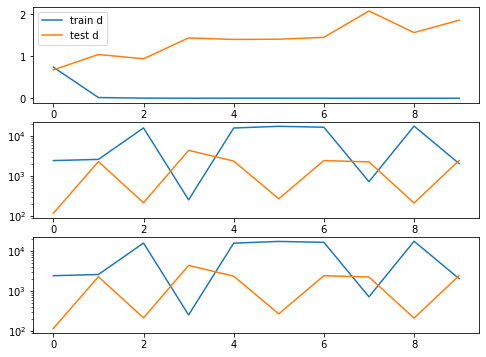

In [43]:
fig, ax = pl.subplots(3,1, figsize = (8,6))
ax[0].plot(train_loss[0,:], label = 'train d')
ax[1].plot(train_loss[1,:], label = 'train g')
ax[2].plot(train_loss[2,:], label = 'train mse')

ax[0].plot(test_loss[0,:], label = 'test d')
ax[1].plot(test_loss[1,:], label = 'test g')
ax[2].plot(test_loss[2,:], label = 'test mse')

ax[1].set_yscale('log')
ax[2].set_yscale('log')

ax[0].legend()

## Plot some of the generated examples 

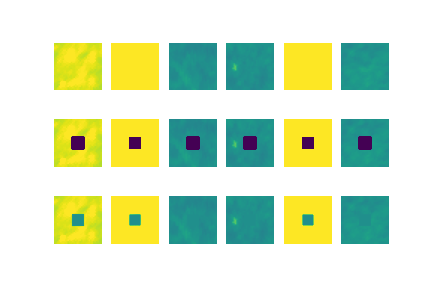

In [44]:
from IPython.display import Image 
Image("./network_output/images/900.png")
#Image("./network_output/images/4500.png")

In [ ]:
#-try rotating, flipping, etc.
#-multi-frequency?